sr_investigation

Description: 
Read relevant PVs from archiver and make pltos  

Usage:
1. define PVs and axes for plotting, and the time interval to plot
    
    Format:  'axis_name': {'PV1_name':'PV1','PB2_name':PV2'...}
        To define a Y range in plotting, please add 'ylim':[<your_low_limit>, <your_high_limit>] 
    
    e.g. 
    to_plot = {
        'beam_curr':{ ## the axis name.
            'LER_beam_curr':'SKB2:BMLDCCT:CURRENT',  ## the variable name and the PV.
            'HER_beam_curr':'SKB2:BMHDCCT:CURRENT'  ## No comma if it's the last item
        }## No comma if it's the last axis.
    }

    time_interval = {
        'start':'2019/12/05 20:00:00', ##in JST.
        'stop':'2019/12/06 01:00:00'
    }


2. read data, user can choose to read data from archiver (2a) or from files (2b)

    2a. extract data from archiver. 

        If PV has substring'SKB2' or 'B2_nsm', try to reach Belle2 archiver
        If PV has substring'PXD', try to reach PXD archiver
        If OV has substring'SVD', try to reach SVD archiver

        User can choose whether to save data to files or not by setting
            save_data = True
        if enabled, the data will be saved to .npy file and .txt files in subfoler 'sr_investigation_datafiles'
    
    2b. once files are saved, user can also read from files since it may be faster.  


3. make plots.
    
    User can define the time interval for plotting.



In [3]:
#1. define PVs and axes for plotting, and the time interval


to_plot = {  
    # axis names: {'PV1_name':'PV1','PB2_name':PV2'..., 'ylim':[low, high]}
    'beam_curr':{
        'LER_beam_curr':'SKB2:BMLDCCT:CURRENT', 
        'HER_beam_curr':'SKB2:BMHDCCT:CURRENT'
    },

#     'beat_Y':{
#         #'LER_beta_Y':'SKB2:CGLOPT:IP:BETA_Y', 
#         'HER_beta_Y':'SKB2:CGHOPT:IP:BETA_Y'
#     },

#     'beta_X':{
#         #'LER_beta_X':'SKB2:CGLOPT:IP:BETA_X', 
#         'HER_beta_X':'SKB2:CGHOPT:IP:BETA_X'
#     },

#     #'number_of_bunch':{
#     #    'HER_NOB':'SKB2:CGHINJ:BKSEL:NOB_SET',
#     #    'LER_NOB':'SKB2:CGLINJ:BKSEL:NOB_SET'
#     #},

    'injection_rate':{
#         'ylim':[-0.75,1.25],
#         'LER_inj_rate':'SKB2:CGLINJ:RATE_AVE',
        'HER_inj_rate':'SKB2:CGHINJ:RATE_AVE'
    },
    
    'injection_eff':{
#         'LER_inj_eff':'SKB2:CGLINJ:EFFICIENCY',
        'HER_inj_eff':'SKB2:CGHINJ:EFFICIENCY'
    },

#     'beam_lifetime':{
#         'HER_lifetime':'SKB2:BMHDCCT:LIFE',
#         'LER_lifetime':'SKB2:BMLDCCT:LIFE'
#     },
    
    'HER_horizontal_orbit':{
        'HER_horizontal_angle':'SKB2:BMH:MQC2RE:POS:PXP'
#         ,'ylim':[-3.55,-3.35]
    },
        
#     'HER_vertical_orbit':{
#         'HER_vertical_angle':'SKB2:BMH:MQC2RE:POS:PYP'
#         ,'ylim':[-0.4,-0.1]
#     },
    
#     'Horizontal_betatron_tune':{
#         'HER_tune_horizontal':'SKB2:CGHOPT:GATED_TUNE_X:MEAS'
#         #,'LER_tune_horizontal':'SKB2:CGLOPT:GATED_TUNE_X:MEAS'
#     },
    
#     'Vertical_betatron_tune':{
#         'HER_tune_vertical':'SKB2:CGHOPT:GATED_TUNE_Y:MEAS'
#         #,'LER_tune_vertical':'SKB2:CGLOPT:GATED_TUNE_Y:MEAS'

#     },
    
#     'PXD_occ':{
#         'ylim':[0,0.3],  # define the range in plotting
#         'PXD_IB':'PXD:OCC:IB:mean', 
#         'PXD_IF':'PXD:OCC:IF:mean',
#         'PXD_OB':'PXD:OCC:OB:mean',
#         'PXD_OF':'PXD:OCC:OF:mean'
#     },

    'PXD_PhotonMonitor_rate':{
        'PXD_photonRate':'PXD:V:PhotonRate:RATE:cur'
    },
    
#     'PXD_PhotonMonitor_frac':{
#         'PXD_photonFrac':'PXD:V:PhotonFraction:VALUE:cur'
#     },
    
#     'ECL_hit_rate':{
#         'ECL_al':'B2_nsm:get:ECLTRG_FAM:rate_al',
#         'ECL_br':'B2_nsm:get:ECLTRG_FAM:rate_br',
#         'ECL_fw':'B2_nsm:get:ECLTRG_FAM:rate_fw'
#     }
}

time_interval = {  # in JST.
    #'start':'2020/03/06 00:00:00',  
    #'stop':'2020/03/06 03:00:00'
    #'start':'2020/03/17 13:00:00',  
    #'stop':'2020/03/18 08:00:00'
    'start':'2020/05/18 22:00:00',  
    'stop':'2020/05/20 02:00:00'
}

print('to plot:', to_plot.keys())
print('in period of ', time_interval)

to plot: dict_keys(['beam_curr', 'injection_rate', 'injection_eff', 'HER_horizontal_orbit', 'PXD_PhotonMonitor_rate'])
in period of  {'start': '2020/05/18 22:00:00', 'stop': '2020/05/20 02:00:00'}


In [5]:
# 2a. read archiver

# if enabled, the data will be saved to .npy file and .txt files in subfoler 'sr_investigation_datafiles'
save_data = False 

import epics_archiver
import datetime
import time
import numpy as np
import os


start_datetime = datetime.datetime.strptime(time_interval['start'], "%Y/%m/%d %H:%M:%S")
stop_datetime = datetime.datetime.strptime(time_interval['stop'], "%Y/%m/%d %H:%M:%S")
#stop_datetime = start_datetime + datetime.timedelta(seconds = 3600)
print('read archiver in period of ', time_interval)

#### Belle2 archiver
b2_archiver = epics_archiver.epics_archiver("172.22.16.120:17668")
b2_archiver_start = b2_archiver.date_parser(start_datetime)
b2_archiver_stop = b2_archiver.date_parser(stop_datetime)
time.sleep(1)

#### PXD archiver
pxd_archiver = epics_archiver.epics_archiver("172.22.18.80:80")
pxd_archiver_start = pxd_archiver.date_parser(start_datetime)
pxd_archiver_stop = pxd_archiver.date_parser(stop_datetime)
time.sleep(1)

#### SVD archiver
svd_archiver = epics_archiver.epics_archiver("172.22.18.120:17668") 
svd_archiver_start = svd_archiver.date_parser(start_datetime)
svd_archiver_stop = svd_archiver.date_parser(stop_datetime)
time.sleep(1)

data_dict={}
for axis in to_plot.keys():
    print(axis)
    for pv_label in to_plot[axis].keys():
        if pv_label == 'ylim': 
                continue
        if 'SKB2' in to_plot[axis][pv_label] or 'B2_nsm' in to_plot[axis][pv_label]:
            data_dict[to_plot[axis][pv_label]] = b2_archiver.getData(to_plot[axis][pv_label], b2_archiver_start, b2_archiver_stop)
        if 'PXD' in to_plot[axis][pv_label]:
            data_dict[to_plot[axis][pv_label]] = pxd_archiver.getData(to_plot[axis][pv_label], pxd_archiver_start, pxd_archiver_stop)

        print(' %s: PV(%s) has %s records'%(pv_label,to_plot[axis][pv_label], len(data_dict[to_plot[axis][pv_label]]['vals'])))
                
## write data to .npy and .txt files, label them with timestamp and put them in 'subfolder'
if save_data:
    
    subfolder = 'sr_investigation_datafiles'    
    print('\n save data to folder: ',subfolder)
    
    timestamp = '%s-%s'%(start_datetime.strftime('%y%m%d%H%M'),stop_datetime.strftime('%y%m%d%H%M'))
    if not os.path.isdir(subfolder):
        os.mkdir(subfolder)
    np.save(os.path.join(subfolder,'data_%s'%timestamp),data_dict)
    print('data_%s.npy'%timestamp)
    
    #import json
    #for axis in to_plot.keys():
    #    for pv_label in to_plot[axis]:
    #        with open(os.path.join(subfolder,'%s_%s_%s-%s.txt'%(axis,pv_label,start_datetime.strftime('%y%m%d%H%M'),stop_datetime.strftime('%y%m%d%H%M'))), 'w') as file:
    #            file.write(json.dumps(data_dict[to_plot[axis][pv_label]]))
    #            file.close()
    
#     for axis in to_plot.keys():
#         for pv_label in to_plot[axis].keys():
#             if pv_label == 'ylim': 
#                 continue
                
#             with open(os.path.join(subfolder,'%s_%s_%s.txt'%(axis,pv_label,timestamp)), 'w') as file:
#                 file.write('pvname: %s \n'%data_dict[to_plot[axis][pv_label]]['pvname'])
#                 file.write('precision: %s\n'%data_dict[to_plot[axis][pv_label]]['precision'])
#                 file.write('time vals\n')
#                 for i in range(len(data_dict[to_plot[axis][pv_label]]['vals'])):
#                     file.write('%s %s \n'%(datetime.datetime.fromtimestamp(data_dict[to_plot[axis][pv_label]]['secs'][i]), data_dict[to_plot[axis][pv_label]]['vals'][i]))
#                 file.close()
#             print('%s_%s_%s.txt'%(axis,pv_label,timestamp))


#     with open(os.path.join(subfolder,'data_%s.txt'%(timestamp)), 'w') as file:

#         for axis in to_plot.keys():
#             for pv_label in to_plot[axis].keys():
#                 if pv_label == 'ylim': 
#                     continue
                
#                 file.write('pvname: %s \n'%data_dict[to_plot[axis][pv_label]]['pvname'])
#                 file.write('precision: %s\n'%data_dict[to_plot[axis][pv_label]]['precision'])
#                 file.write('time vals\n')
#                 for i in range(len(data_dict[to_plot[axis][pv_label]]['vals'])):
#                     file.write('%s %.6f \n'%(datetime.datetime.fromtimestamp(data_dict[to_plot[axis][pv_label]]['secs'][i]), data_dict[to_plot[axis][pv_label]]['vals'][i]))
#                 file.close()
#             print('%s_%s_%s.txt'%(axis,pv_label,timestamp))


read archiver in period of  {'start': '2020/05/18 22:00:00', 'stop': '2020/05/20 02:00:00'}
beam_curr
 LER_beam_curr: PV(SKB2:BMLDCCT:CURRENT) has 99922 records
 HER_beam_curr: PV(SKB2:BMHDCCT:CURRENT) has 100766 records
injection_rate
 HER_inj_rate: PV(SKB2:CGHINJ:RATE_AVE) has 25189 records
injection_eff
 HER_inj_eff: PV(SKB2:CGHINJ:EFFICIENCY) has 94001 records
HER_horizontal_orbit
 HER_horizontal_angle: PV(SKB2:BMH:MQC2RE:POS:PXP) has 20595 records
PXD_PhotonMonitor_rate
 PXD_photonRate: PV(PXD:V:PhotonRate:RATE:cur) has 11015 records


In [6]:
# 2b. read from .npy file in subfoler 'sr_investigation_datafiles'

import datetime
import numpy as np
import os


start_datetime = datetime.datetime.strptime(time_interval['start'], "%Y/%m/%d %H:%M:%S")
stop_datetime = datetime.datetime.strptime(time_interval['stop'], "%Y/%m/%d %H:%M:%S")

timestamp = '%s-%s'%(start_datetime.strftime('%y%m%d%H%M'),stop_datetime.strftime('%y%m%d%H%M'))
filename = os.path.join('sr_investigation_datafiles','data_%s.npy'%timestamp)

if os.path.isfile(filename):
    data_dict = np.load(filename).item()
    print('load data from file:', filename)
else:
    print('can not find the file: ',filename)
    

can not find the file:  sr_investigation_datafiles/data_2005182200-2005200200.npy


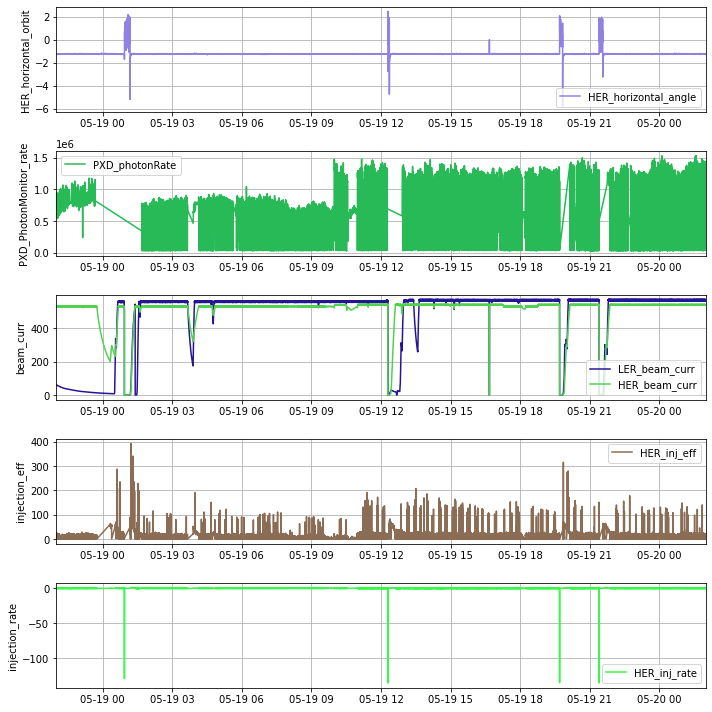

In [7]:
## 3. make plots

#if enabled, please define the start and stop timestamp in line#10,11
define_plot_interval = False

#%matplotlib notebook

if define_plot_interval:
    
    plot_interval = {
        'start':'2020/05/21 23:30:00',  
        'stop':'2020/05/22 02:00:00'
    }
    
else:
    plot_interval = time_interval.copy()
    

import matplotlib.pyplot as plt
import matplotlib.dates as mdate

plot_start = datetime.datetime.strptime(plot_interval['start'], "%Y/%m/%d %H:%M:%S")
plot_stop = datetime.datetime.strptime(plot_interval['stop'], "%Y/%m/%d %H:%M:%S")


nplots = len(to_plot.keys())

fig, ax = plt.subplots(nplots,figsize=(10,2*nplots))#, sharex=True)

for i,axis in enumerate(sorted(to_plot.keys())):
    for pv_label in sorted(to_plot[axis].keys(), reverse=True):
        if pv_label == 'ylim': 
                continue
        ax[i].plot_date([mdate.date2num(datetime.datetime.fromtimestamp(t)) for t in data_dict[to_plot[axis][pv_label]]['secs']],data_dict[to_plot[axis][pv_label]]['vals'],c=np.random.rand(3,),ls='-',marker='', label=pv_label)
    ax[i].legend()
    #ax[i].set_xlabel('[JST]')
    ax[i].set_ylabel(axis)
    if 'ylim' in to_plot[axis].keys():
        margin = 0.05*np.abs(to_plot[axis]['ylim'][0]-to_plot[axis]['ylim'][1])
        ax[i].set_ylim(to_plot[axis]['ylim'][0]-margin, to_plot[axis]['ylim'][1]+margin)
    ax[i].grid()
    ax[i].set_xlim(mdate.date2num(plot_start), mdate.date2num(plot_stop))

plt.tight_layout()
plt.show()